In [ ]:
#hide
#from your_lib.core import *

# `deepfeatx`: Deep Learning Feature Extractor of Images using Transfer Learning Models

> Helper for automatic extraction of features from images (and soon text as well) from transfer learning models like ResNet, VGG16 and EfficientNet.

## Install

In [ ]:
#hide_output
!pip install deepfeatx

## Why this project has been created
- Fill the gap between ML and DL thus allowing estimators beyond only neural networks for computer vision and NLP problems
- Neural network models are too painful to setup and train - data generators, optimizers, learning rates, loss functions, training loops, batch size, etc. 
- State of the art results are possible thanks to pretrained models that allows feature extraction
- With this library we can handle those problems as they were traditional machine learning problems
- Possibility of using low-code APIs like `scikit-learn` for computer vision and NLP problems

## Usage
### Extracting features from an image

In [ ]:
from deepfeatx.image import ImageFeatureExtractor
fe = ImageFeatureExtractor()

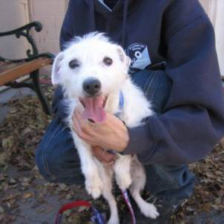

In [ ]:
im_url='https://raw.githubusercontent.com/WittmannF/deepfeatx/master/sample_data/cats_vs_dogs/valid/dog/dog.124.jpg'
fe.read_img_url(im_url)

In [ ]:
fe.url_to_vector(im_url)

array([[0.28227222, 1.0504329 , 0.11333513, ..., 0.18499821, 0.02220216,
        0.06158591]], dtype=float32)

### Extracting Features from a Folder with Images

In [ ]:
!git clone https://github.com/WittmannF/image-scraper.git

Cloning into 'image-scraper'...
remote: Enumerating objects: 543, done.
remote: Counting objects: 100% (543/543), done.
remote: Compressing objects: 100% (536/536), done.
remote: Total 543 (delta 12), reused 521 (delta 3), pack-reused 0
Receiving objects: 100% (543/543), 23.58 MiB | 43.83 MiB/s, done.
Resolving deltas: 100% (12/12), done.


In [ ]:
df=fe.extract_features_from_directory('image-scraper/images/pug',
                                   classes_as_folders=False,
                                   export_vectors_as_df=True)

df.head()

Found 4 validated image filenames.
1/1 [==============================] - 1s 1s/step


,filepaths,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025,2026,2027,2028,2029,2030,2031,2032,2033,2034,2035,2036,2037,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,image-scraper/images/pug/efd08a2dc5.jpg,0.030706,0.042392,0.422986,1.316509,0.020907,0.000000,0.081956,0.404422,0.489834,0.004070,0.046379,0.438150,0.181135,0.013462,0.177939,0.000000,0.007675,0.346413,0.774563,0.242160,0.146554,0.000000,0.374704,0.546130,0.914375,0.034065,0.018123,0.018173,0.137671,0.062699,0.054896,0.461135,0.121660,0.041247,0.389360,1.212443,0.021843,0.000000,0.583172,...,0.048073,0.858236,0.054315,0.176547,0.009346,0.220590,1.808879,0.165877,0.446522,0.181712,0.076804,0.651420,0.812974,0.710875,0.331778,0.112184,0.294079,0.075776,0.000000,1.752276,0.279192,0.541461,0.226151,0.000000,0.556450,0.101981,0.666771,0.006849,0.085295,0.020708,0.013765,0.642072,1.818820,0.299440,0.000000,0.419997,0.200106,0.179524,0.026852,0.079208
1,image-scraper/images/pug/6fb189ce56.jpg,0.373005,0.102007,0.097662,0.362927,0.549804,0.118015,0.000000,0.104320,0.102526,0.013431,0.358213,0.404455,0.124487,0.050493,0.120028,0.346251,0.070185,0.262804,0.808682,0.055136,0.006087,0.757376,0.097778,0.420553,0.000000,0.141114,0.010222,0.000000,0.233845,0.908515,0.023404,0.637513,0.022050,0.084186,0.084896,0.299784,0.000000,0.015850,0.100193,...,0.288275,0.037123,0.045735,0.374429,0.196037,0.734308,3.006210,0.114692,0.981330,0.853356,0.000000,0.103360,0.988711,0.621975,0.000000,0.136326,0.352058,0.138432,0.000000,0.149371,0.004514,0.011803,0.257658,0.208908,0.029987,0.341993,0.078165,0.177329,0.025573,0.002849,0.210634,0.213147,0.013510,0.574434,0.017234,0.628008,0.000000,0.184550,0.000000,0.248099
2,image-scraper/images/pug/ee815ebc87.jpg,0.263904,0.430294,0.391808,0.033076,0.200174,0.019310,0.002792,0.129120,0.050257,0.212521,0.253893,0.226962,0.343641,0.071063,0.003507,0.000000,0.000000,0.291578,1.115863,0.053286,0.000000,0.114654,0.092095,0.668449,0.319849,0.037851,0.514418,0.028072,0.088368,2.914616,0.000000,0.385466,0.039530,0.117206,1.620699,2.245774,0.551754,0.753468,0.002836,...,0.004382,0.233663,0.290555,0.111746,0.369157,0.413205,1.606386,0.328596,0.030728,0.785285,0.047967,0.530228,0.399490,0.710600,0.000000,0.070264,0.080831,0.044579,0.018119,0.173507,0.032501,0.462589,0.140939,0.064460,0.020042,1.105275,0.220959,0.062867,0.025815,0.643085,0.048243,0.147806,1.430153,0.266686,0.005126,0.158225,0.097526,0.005045,0.060016,1.109626
3,image-scraper/images/pug/24d0f1eee3.jpg,0.068498,0.319734,0.081250,1.248271,0.035602,0.003398,0.000000,0.131528,0.099515,0.153028,0.124836,0.462332,0.027325,0.139767,0.060380,0.000000,0.122781,0.838560,0.000000,0.112821,0.624077,0.000000,0.053588,0.492699,1.002087,0.000000,0.622109,0.000000,0.000000,0.718141,0.000000,0.430249,0.110824,0.306448,1.200562,0.156815,0.001156,0.301857,0.915826,...,0.038859,0.521360,0.000000,0.051310,0.041922,0.394816,0.065257,0.014697,0.732560,0.330840,0.000000,0.084516,0.998141,0.499400,0.048280,0.270612,0.224201,0.015745,0.024890,0.671853,0.052918,0.386016,0.528613,0.068114,0.304690,0.543489,0.005538,0.212559,0.000000,0.064679,0.258502,1.042543,0.691716,0.264938,0.112621,0.927996,0.050389,0.000000,0.087217,0.066992


### Extracting Features from a directory having one sub-folder per class

If the directory structure is the following:
```
main_directory/
...class_a/
......a_image_1.jpg
......a_image_2.jpg
...class_b/
......b_image_1.jpg
......b_image_2.jpg
```
We can enter `main_directory` as input by changing `classes_as_folders` as True:

In [ ]:
df=fe.extract_features_from_directory('image-scraper/images/',
                                      classes_as_folders=True,
                                      export_vectors_as_df=True,
                                      export_class_names=True)

df.head()

Found 504 images belonging to 6 classes.
16/16 [==============================] - 3s 204ms/step


,filepaths,classes,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025,2026,2027,2028,2029,2030,2031,2032,2033,2034,2035,2036,2037,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,image-scraper/images/chihuahua/00dcf98689.jpg,chihuahua,0.640898,0.887127,0.017012,0.723458,0.164907,0.010150,0.042344,0.987458,0.000000,0.014738,1.079895,0.402594,0.813250,0.898078,0.283853,2.501164,0.010436,0.805332,0.355824,0.256257,0.000000,0.040217,0.037436,0.693020,0.079267,0.314281,0.078728,0.721479,0.109187,0.159317,0.231705,1.474535,0.184643,1.271005,0.379876,1.453021,0.380090,0.907110,...,0.020598,0.286543,0.002142,0.030759,0.660899,0.103130,1.164128,0.371421,0.350240,0.330034,0.053406,0.000000,0.037163,0.444834,0.212866,0.492152,0.874334,0.237795,0.115668,0.348703,0.458247,0.558596,0.192963,0.161454,0.085633,0.450116,0.200245,0.000000,0.250926,0.265246,0.289272,0.182084,0.638065,0.092434,0.212790,0.077479,0.255031,0.006371,0.489620,0.028672
1,image-scraper/images/chihuahua/01ee02c2fb.jpg,chihuahua,0.357992,0.128554,0.227736,0.652591,0.014283,0.092680,0.049545,0.319636,0.483190,0.883061,0.594676,1.381473,0.026144,0.065988,0.725521,0.713691,0.325972,0.533582,0.180176,0.342377,0.237265,0.000000,0.261737,0.221033,0.032584,0.351651,0.014421,0.414543,0.000000,0.866484,0.107451,0.203948,0.368253,0.057964,0.730031,1.100734,0.018189,0.685484,...,0.083613,0.029979,0.002172,0.000702,0.414535,0.217415,2.571724,0.424689,1.096397,0.501114,0.079659,0.196180,0.939940,0.698140,0.201000,0.156991,0.007649,0.506530,0.033568,0.236135,0.247923,0.000000,0.019695,0.024427,1.090950,0.059133,0.157476,0.020930,0.278073,0.261410,0.061090,0.526585,2.363333,0.160860,0.000000,0.008739,0.401080,1.377396,0.383463,0.434211
2,image-scraper/images/chihuahua/040df01fb4.jpg,chihuahua,0.163307,0.383920,0.029491,0.985439,0.866045,0.098337,0.000000,0.634066,0.008103,0.265017,0.855049,0.377369,0.956488,0.048767,0.111992,0.995532,0.045995,0.000000,0.100024,0.662924,0.000000,0.622694,1.983342,0.409406,0.135824,1.269810,0.000000,0.938176,0.231427,0.952571,0.093252,0.891095,0.095773,0.074930,2.476267,0.419716,0.139721,0.809897,...,1.201412,0.007480,0.344691,0.113256,0.045065,0.000000,0.000000,0.010362,0.000000,0.051770,0.089685,0.875670,0.746090,0.968278,0.339250,0.000000,0.088543,0.181245,0.727058,0.932653,0.055956,0.388373,0.000000,0.027907,1.606237,0.018162,1.293559,0.025541,0.134964,0.907378,0.188045,0.000000,0.056569,1.115317,0.000000,0.005085,0.072279,0.555854,0.333002,0.413305
3,image-scraper/images/chihuahua/04d8487a97.jpg,chihuahua,0.206925,3.128514,0.147507,0.104672,0.554030,2.415103,0.009965,0.171641,0.023494,0.093665,1.055174,0.416101,0.000000,0.035469,0.795537,0.347654,0.110582,0.966725,1.661129,0.609166,0.174202,0.021658,0.000000,0.413250,0.059435,0.672011,0.194659,0.093386,0.496726,0.614268,3.678215,1.522481,0.444912,0.170048,0.081268,1.027889,0.120007,0.060579,...,0.800862,0.063278,0.014473,1.348824,0.430826,0.588406,1.584016,1.293362,0.641694,0.218196,0.000000,2.098822,0.102527,0.850325,0.020062,0.407770,1.071674,0.093944,0.374237,0.304633,0.035681,2.885260,0.085211,0.517855,1.634241,0.173959,2.049943,0.297248,0.594727,0.031904,0.000000,1.297840,1.165449,0.562891,0.000000,0.395751,0.250796,0.295067,0.534072,0.051334
4,image-scraper/images/chihuahua/0d9fa44dea.jpg,chihuahua,0.233232,0.355026,0.453335,0.060354,0.479403,0.000000,0.099391,0.223717,0.000000,0.166825,1.043408,0.212968,0.047919,0.011581,0.824220,1.071727,0.322423,2.238094,0.036986,0.051276,0.000000,0.119234,0.375851,0.939742,0.512171,0.052703,0.000000,0.405724,0.000000,0.796944,0.146392,0.609674,0.342722,0.119698,0.300473,1.781652,0.003325,0.372860,...,0.170190,0.019021,0.175870,0.058903,0.195530,0.070747,1.904165,0.143940,1.018590,0.010964,0.008130,1.318745,1.122194,1.022019,0.679122,0.080073,0.821368,0.255947,0.000000,0.811980,0.124174,0.211784,0.911710,0.0577

The usage of `export_class_names=True` will add a new column to the dataframe with the classes names.

## Examples
### Cats vs Dogs using Keras vs `deepfeatx`
First let's compare the code of one of the simplest deep learning libraries (Keras) with `deepfeatx`. As example, let's use a subset of Cats vs Dogs:

In [ ]:
from deepfeatx.image import download_dataset
download_dataset('https://github.com/dl7days/datasets/raw/master/cats-dogs-data.zip', 'cats-dogs-data.zip')

Unzipping Dataset
Removing .zip file


Here's the keras implementation for a great performance result:

In [ ]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, GlobalAveragePooling2D
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

TARGET_SHAPE = (224, 224, 3)
TRAIN_PATH = 'cats-dogs-data/train'
VALID_PATH = 'cats-dogs-data/valid'

datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
train_gen = datagen.flow_from_directory(TRAIN_PATH, 
                                        target_size=TARGET_SHAPE[:2], 
                                        class_mode='sparse')
valid_gen = datagen.flow_from_directory(VALID_PATH, 
                                        target_size=TARGET_SHAPE[:2], 
                                        class_mode='sparse',
                                        shuffle=False)

base_model = ResNet50(include_top=False, input_shape=TARGET_SHAPE)

for layer in base_model.layers:
    layer.trainable=False
    
model = Sequential([base_model,
                    GlobalAveragePooling2D(),
                    Dense(1024, activation='relu'),
                    Dense(2, activation='softmax')])

model.compile(optimizer=Adam(lr=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.fit(train_gen, epochs=3, validation_data=valid_gen)

Found 2000 images belonging to 2 classes.
Found 400 images belonging to 2 classes.
Epoch 1/3
63/63 [==============================] - 14s 181ms/step - loss: 0.1664 - accuracy: 0.9313 - val_loss: 0.0709 - val_accuracy: 0.9775
Epoch 2/3
63/63 [==============================] - 11s 168ms/step - loss: 0.0213 - accuracy: 0.9946 - val_loss: 0.0457 - val_accuracy: 0.9850
Epoch 3/3
63/63 [==============================] - 11s 167ms/step - loss: 0.0061 - accuracy: 1.0000 - val_loss: 0.0453 - val_accuracy: 0.9900


By looking at `val_accuracy` we can confirm the results seems great. Let's also plot some other metrics:

In [ ]:
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
import seaborn as sns
y_pred = model.predict(valid_gen)
y_test = valid_gen.classes
roc = roc_auc_score(y_test, y_pred[:, 1])
print("ROC AUC Score", roc)

ROC AUC Score 0.9989


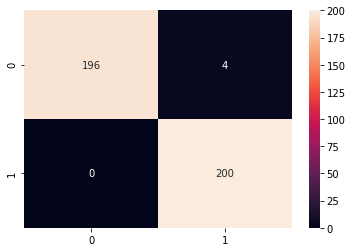

In [ ]:
cm=confusion_matrix(y_test, y_pred.argmax(axis=1))
sns.heatmap(cm, annot=True, fmt='g')

Although we got an almost perfect clssifier, there are multiple details that someone who is coming from sklearn has to be careful when using Keras, for example:
- Correctly setup the Data Generator
- Fine tune the learning rate
- Adjust the batch size

Now let's replicate the same results using `deepfeatx`:

In [ ]:
from deepfeatx.image import ImageFeatureExtractor
from sklearn.linear_model import LogisticRegression

TRAIN_PATH = 'cats-dogs-data/train'
VALID_PATH = 'cats-dogs-data/valid'

fe = ImageFeatureExtractor()

train=fe.extract_features_from_directory(TRAIN_PATH, 
                                         classes_as_folders=True,
                                         export_class_names=True)
test=fe.extract_features_from_directory(VALID_PATH, 
                                         classes_as_folders=True,
                                         export_class_names=True)

X_train, y_train = train.drop(['filepaths', 'classes'], axis=1), train['classes']
X_test, y_test = test.drop(['filepaths', 'classes'], axis=1), test['classes']
lr = LogisticRegression().fit(X_train, y_train)

Found 2000 images belonging to 2 classes.
63/63 [==============================] - 10s 141ms/step
Found 400 images belonging to 2 classes.
13/13 [==============================] - 2s 140ms/step


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [ ]:
roc_auc_score(y_test, lr.predict_proba(X_test)[:, 1])

0.9996

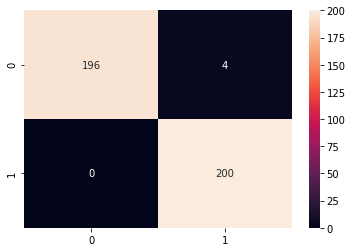

In [ ]:
import seaborn as sns
cm=confusion_matrix(y_test, lr.predict(X_test))
sns.heatmap(cm, annot=True, fmt='g')

Even though the code is smaller, is still as powerful as the keras code and also very flexible. The most important part is the feature extraction, which `deepfeatx` take care for us, and the rest can be performed as any other ML problem.